This python script describes how the optimal start and end time are determined with the training set. This script is made for this thesis project and uses some functions from pysteps.

Made by Florian Dekker and Kevin Luo

## Install pysteps

In [ ]:
!pip install pysteps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.9/568.9 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jsmin-3.0.1-py3-none-any.whl
  Created wheel for pysteps: filename=pysteps-1.9.0-cp310-cp310-linux_x86_64.whl size=1465863 sha256=e0017dd89d18a93bbffb98a52a26e4e6024febf7d8a4d095cd93e5f2eadab184
  Stored in directory: /root/.cache/pip/wheels/51/d7/40/75d28e162f23b5efd03300d53586d76645dbbc80cc761c3130
Successfully built pysteps


## Import packages

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import random
random.seed(1)

from datetime import datetime, timedelta
import google.colab.files

import pysteps
from pysteps.verification.interface import get_method
from pysteps.visualization.precipfields import plot_precip_field
from pysteps import nowcasts
from pysteps.utils import conversion
from scipy.stats import rankdata

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



## Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Specify the dates

This part loads the data from the specified dates. The data that are loaded are the actual observation and downsized, DGMR output and Harmonie.

In [ ]:
# Specify start and end
start_date_str = '202405241800'
end_date_str = '202406110600'

true_combined = None
nwp_combined = None
DGMR_combined_extended_down = None
true_downsized_combined = None

start_date = datetime.strptime(start_date_str, '%Y%m%d%H%M')
end_date = datetime.strptime(end_date_str, '%Y%m%d%H%M')

skip_start_date = datetime.strptime('202405270600', '%Y%m%d%H%M')
skip_end_date = datetime.strptime('202406040000', '%Y%m%d%H%M')


current_date = start_date
while current_date <= end_date:
    if skip_start_date <= current_date < skip_end_date:
        current_date += timedelta(hours=6)
        continue

    folder = current_date.strftime('%Y%m%d%H%M')
    filename = (current_date+timedelta(hours=5)).strftime('%Y%m%d%H%M')
    if folder != '202406060600':
      true = np.load(f'/content/drive/MyDrive/Colab Notebooks/Resultaten/{folder}/true_{filename}.npy')
      nwp = np.load(f'/content/drive/MyDrive/Colab Notebooks/Resultaten/{folder}/nwp_all_{filename}.npy')
      dgmr = np.load(f'/content/drive/MyDrive/Colab Notebooks/Resultaten/{folder}/DGMR_combined_extended_down_{filename}.npy')
      true_downsized = np.load(f'/content/drive/MyDrive/Colab Notebooks/Resultaten/{folder}/true_downsized_{filename}.npy')

      if true_combined is None:
        true_combined = true[np.newaxis, ...]  # Create a new axis for stacking
      else:
        true_combined = np.concatenate((true_combined, true[np.newaxis, ...]), axis=0)

      if true_downsized_combined is None:
        true_downsized_combined = true_downsized[np.newaxis, ...]  # Create a new axis for stacking
      else:
        true_downsized_combined = np.concatenate((true_downsized_combined, true_downsized[np.newaxis, ...]), axis=0)

      if nwp_combined is None:
        nwp_combined = nwp[np.newaxis, ...]
      else:
        nwp_combined = np.concatenate((nwp_combined, nwp[np.newaxis, ...]), axis = 0)

      if DGMR_combined_extended_down is None:
        DGMR_combined_extended_down = dgmr[np.newaxis, ...]
      else:
        DGMR_combined_extended_down = np.concatenate((DGMR_combined_extended_down, dgmr[np.newaxis, ...]), axis = 0)
    current_date += timedelta(hours=6)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/Resultaten/202405151800/true_202405152300.npy'

In [ ]:
print(true_combined.shape, DGMR_combined_extended_down.shape, true_downsized_combined.shape)
nwp_combined[1].shape

(40, 31, 765, 700) (40, 31, 143, 162) (40, 31, 143, 162)


(31, 143, 162)

## Blending function Pysteps

This function is from the pySTEPS library and altered so that it can use the DGMR nowcasts. The original function can be found here: https://github.com/pySTEPS/pysteps/blob/master/pysteps/blending/linear_blending.py

In [ ]:
"""
pysteps.nowcasts.linear_blending
================================

Linear blending method to blend (ensemble) nowcasts and (ensemble) Numerical
Weather Prediction (NWP) forecasts. The method uses a predefined start and end
time for the blending. Before this start time, the resulting blended forecasts only
consists of the nowcast(s). In between the start and end time, the nowcast(s)
weight decreases and NWP forecasts weight increases linearly from 1(0) to
0(1). After the end time, the blended forecast entirely consists of the NWP
forecasts. The saliency-based blending method also takes into account the pixel
intensities and preserves them if they are strong enough based on their ranked salience.

Implementation of the linear blending and saliency-based blending between nowcast and NWP data.

.. autosummary::
    :toctree: ../generated/

    forecast
"""

import numpy as np
from pysteps import nowcasts
from pysteps.utils import conversion
from scipy.stats import rankdata


def forecast(
    precip,
    precip_metadata,
    timesteps,
    timestep,
    precip_nwp=None,
    precip_nwp_metadata=None,
    start_blending=120,
    end_blending=240,
    fill_nwp=True,
    saliency=False,
    nowcast_kwargs=None,
):
    """Generate a forecast by linearly or saliency-based blending of nowcasts with NWP data

    Parameters
    ----------
    precip: array_like
      Array containing the input precipitation field(s) ordered by timestamp
      from oldest to newest. The time steps between the inputs are assumed
      to be regular.
    precip_metadata: dict
        Metadata dictionary containing (at least) the transform, unit and threshold
        attributes as described in the documentation of :py:mod:`pysteps.io.importers`.
    velocity; array_like
      Array of shape (2, m, n) containing the x- and y-components of the advection
      field. The velocities are assumed to represent one time step between the
      inputs. All values are required to be finite.
    timesteps: int
      Number of time steps to forecast.
    timestep: int or float
      The time difference (in minutes) between consecutive forecast fields.
    nowcast_method: str
      Name of the nowcasting method. See :py:mod:`pysteps.nowcasts.interface`
      for the list of available methods.
    precip_nwp: array_like or NoneType, optional
      Array of shape (timesteps, m, n) in the case of no ensemble or
      of shape (n_ens_members, timesteps, m, n) in the case of an ensemble
      containing the NWP precipitation fields ordered by timestamp from oldest
      to newest. The time steps between the inputs are assumed to be regular
      (and identical to the time step between the nowcasts). If no NWP
      data is given the value of precip_nwp is None and no blending will be performed.
    precip_nwp_metadata: dict or NoneType, optional
        NWP metadata dictionary containing (at least) the transform, unit and threshold
        attributes as described in the documentation of :py:mod:`pysteps.io.importers`.
    start_blending: int, optional
      Time stamp (in minutes) after which the blending should start. Before this
      only the nowcast data is used.
    end_blending: int, optional
      Time stamp (in minutes) after which the blending should end. Between
      start_blending and end_blending the nowcasts and NWP data are linearly
      merged with each other. After end_blending only the NWP data is used.
    fill_nwp: bool, optional
      Standard value is True. If True, the NWP data will be used to fill in the
      no data mask of the nowcast.
    saliency: bool, optional
      Default value is False. If True, saliency will be used for blending. The blending
      is based on intensities and forecast times as described in :cite:`Hwang2015`. The blended
      product preserves pixel intensities with time if they are strong enough based on their ranked
      salience.
    nowcast_kwargs: dict, optional
      Dictionary containing keyword arguments for the nowcast method.


    Returns
    -------
    precip_blended: ndarray
      Array of shape (timesteps, m, n) in the case of no ensemble or
      of shape (n_ens_members, timesteps, m, n) in the case of an ensemble
      containing the precipation forecast generated by linearly blending
      the nowcasts and the NWP data. n_ens_members equals the maximum no. of
      ensemble members in either the nowcast or nwp model(s).
    """

    if nowcast_kwargs is None:
        nowcast_kwargs = dict()

# This part is modified and replaced the nowcast with DGMR output

    precip_nowcast = precip

# From here, the original code continues

    # # Calculate the nowcasts
    # nowcast_method_func = nowcasts.get_method(nowcast_method)
    # precip_nowcast = nowcast_method_func(
    #     precip,
    #     velocity,
    #     timesteps,
    #     **nowcast_kwargs,
    # )

    # # Make sure that precip_nowcast and precip_nwp are in mm/h
    # precip_nowcast, _ = conversion.to_rainrate(precip_nowcast, metadata=precip_metadata)

    # Check if NWP data is given as input
    if precip_nwp is not None:
        precip_nwp, _ = conversion.to_rainrate(precip_nwp, metadata=precip_nwp_metadata)

        if len(precip_nowcast.shape) == 4:
            n_ens_members_nowcast = precip_nowcast.shape[0]
            if n_ens_members_nowcast == 1:
                precip_nowcast = np.squeeze(precip_nowcast)
        else:
            n_ens_members_nowcast = 1

        if len(precip_nwp.shape) == 4:
            n_ens_members_nwp = precip_nwp.shape[0]
            if n_ens_members_nwp == 1:
                precip_nwp = np.squeeze(precip_nwp)
        else:
            n_ens_members_nwp = 1

        # Now, repeat the nowcast ensemble members or the nwp models/members until
        # it has the same amount of members as n_ens_members_max. For instance, if
        # you have 10 ensemble nowcasts members and 3 NWP members, the output will
        # be an ensemble of 10 members. Hence, the three NWP members are blended
        # with the first three members of the nowcast (member one with member one,
        # two with two, etc.), subsequently, the same NWP members are blended with
        # the next three members (NWP member one with member 4, NWP member 2 with
        # member 5, etc.), until 10 is reached.
        n_ens_members_max = max(n_ens_members_nowcast, n_ens_members_nwp)
        n_ens_members_min = min(n_ens_members_nowcast, n_ens_members_nwp)

        if n_ens_members_min != n_ens_members_max:
            if n_ens_members_nwp == 1:
                precip_nwp = np.repeat(
                    precip_nwp[np.newaxis, :, :], n_ens_members_max, axis=0
                )
            elif n_ens_members_nowcast == 1:
                precip_nowcast = np.repeat(
                    precip_nowcast[np.newaxis, :, :], n_ens_members_max, axis=0
                )
            else:
                repeats = [
                    (n_ens_members_max + i) // n_ens_members_min
                    for i in range(n_ens_members_min)
                ]

                if n_ens_members_nwp == n_ens_members_min:
                    precip_nwp = np.repeat(precip_nwp, repeats, axis=0)
                elif n_ens_members_nowcast == n_ens_members_min:
                    precip_nowcast = np.repeat(precip_nowcast, repeats, axis=0)

        # Check if dimensions are correct
        assert (
            precip_nwp.shape == precip_nowcast.shape
        ), "The dimensions of precip_nowcast and precip_nwp need to be identical: dimension of precip_nwp = {} and dimension of precip_nowcast = {}".format(
            precip_nwp.shape, precip_nowcast.shape
        )

        # Initialise output
        precip_blended = np.zeros_like(precip_nowcast)

        # Calculate the weights
        for i in range(timesteps):
            # Calculate what time we are at
            t = (i + 1) * timestep

            if n_ens_members_max == 1:
                ref_dim = 0
            else:
                ref_dim = 1

            # apply blending
            # compute the slice indices
            slc_id = _get_slice(precip_blended.ndim, ref_dim, i)

            # Calculate the weight with a linear relation (weight_nwp at start_blending = 0.0)
            # and (weight_nwp at end_blending = 1.0)
            weight_nwp = (t - start_blending) / (end_blending - start_blending)

            # Set weights at times before start_blending and after end_blending
            if weight_nwp <= 0.0:
                weight_nwp = 0.0
                precip_blended[slc_id] = precip_nowcast[slc_id]

            elif weight_nwp >= 1.0:
                weight_nwp = 1.0
                precip_blended[slc_id] = precip_nwp[slc_id]

            else:
                # Calculate weight_nowcast
                weight_nowcast = 1.0 - weight_nwp

                # Calculate output by combining precip_nwp and precip_nowcast,
                # while distinguishing between ensemble and non-ensemble methods
                if saliency:
                    ranked_salience = _get_ranked_salience(
                        precip_nowcast[slc_id], precip_nwp[slc_id]
                    )
                    ws = _get_ws(weight_nowcast, ranked_salience)
                    precip_blended[slc_id] = (
                        ws * precip_nowcast[slc_id] + (1 - ws) * precip_nwp[slc_id]
                    )

                else:
                    precip_blended[slc_id] = (
                        weight_nwp * precip_nwp[slc_id]
                        + weight_nowcast * precip_nowcast[slc_id]
                    )

            # Find where the NaN values are and replace them with NWP data
            if fill_nwp:
                nan_indices = np.isnan(precip_blended)
                precip_blended[nan_indices] = precip_nwp[nan_indices]
    else:
        # If no NWP data is given, the blended field is simply equal to the nowcast field
        precip_blended = precip_nowcast

    return precip_blended


def _get_slice(n_dims, ref_dim, ref_id):
    """source: https://stackoverflow.com/a/24399139/4222370"""
    slc = [slice(None)] * n_dims
    slc[ref_dim] = ref_id
    return tuple(slc)


def _get_ranked_salience(precip_nowcast, precip_nwp):
    """Calculate ranked salience, which show how close the pixel is to the maximum intensity difference [r(x,y)=1]
      or the minimum intensity difference [r(x,y)=0]

    Parameters
    ----------
    precip_nowcast: array_like
      Array of shape (m,n) containing the extrapolated precipitation field at a specified timestep
    precip_nwp: array_like
      Array of shape (m,n) containing the NWP fields at a specified timestep

    Returns
    -------
    ranked_salience:
      Array of shape (m,n) containing ranked salience
    """

    # calcutate normalized intensity
    if np.max(precip_nowcast) == 0:
        norm_nowcast = np.zeros_like(precip_nowcast)
    else:
        norm_nowcast = precip_nowcast / np.max(precip_nowcast)

    if np.max(precip_nwp) == 0:
        norm_nwp = np.zeros_like(precip_nwp)
    else:
        norm_nwp = precip_nwp / np.max(precip_nwp)

    diff = norm_nowcast - norm_nwp

    # Calculate ranked salience, based on dense ranking method, in which equally comparable values receive the same ranking number
    ranked_salience = rankdata(diff, method="dense").reshape(diff.shape).astype("float")
    ranked_salience /= ranked_salience.max()

    return ranked_salience


def _get_ws(weight, ranked_salience):
    """Calculate salience weight based on linear weight and ranked salience as described in :cite:`Hwang2015`.
      Cells with higher intensities result in larger weights.

    Parameters
    ----------
    weight: int
      Varying between 0 and 1
    ranked_salience: array_like
      Array of shape (m,n) containing ranked salience

    Returns
    -------
    ws: array_like
      Array of shape (m,n) containing salience weight, which preserves pixel intensties with time if they are strong
      enough based on the ranked salience.
    """

    # Calculate salience weighte
    ws = 0.5 * (
        (weight * ranked_salience)
        / (weight * ranked_salience + (1 - weight) * (1 - ranked_salience))
        + (
            np.sqrt(ranked_salience**2 + weight**2)
            / (
                np.sqrt(ranked_salience**2 + weight**2)
                + np.sqrt((1 - ranked_salience) ** 2 + (1 - weight) ** 2)
            )
        )
    )
    return ws

## Exhaustive search: optimal start and end time

This part describes how the optimal start and end time for the blending is determined. An exhaustive search approach is applied, where all possible combinations of start and end times are determined. For each combination, the pod, far and fss are calculated. The combination with the highest score is the optimal start and end time.

In [ ]:
radar_metadata =  {'projection': '+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378137 +b=6356752 +x_0=0 +y_0=0',
        "x1": 110000.,
        "y1": -4304999.2899712,
        "x2": 700001.,
        "y2": -3759995.2899712,
        'xpixelsize': 1000.0,
        'ypixelsize': 1000.0,
        'cartesian_unit': 'm',
        'yorigin': 'upper',
        'institution': 'KNMI - Royal Netherlands Meteorological Institute',
        'accutime': 5,
        'unit': 'mm/h',
        'transform': None,
        'zerovalue': 0.0,
        'threshold': 0.0003918377307968165,
        'zr_a': 200.0,
        'zr_b': 1.6}

nwp_metadata =  {'projection': 'epsg4326',
        "x1": 110000.,
        "y1": -4304999.2899712,
        "x2": 700001.,
        "y2": -3759995.2899712,
        'xpixelsize': 2500.0,
        'ypixelsize': 2500.0,
        'cartesian_unit': 'm',
        'yorigin': 'upper',
        'institution': 'KNMI - Royal Netherlands Meteorological Institute',
        'accutime': 60,
        'unit': 'mm/h',
        'transform': None,
        'zerovalue': 0.0,
        'threshold': 0.0003918377307968165,
        'zr_a': 200.0,
        'zr_b': 1.6}

Import the POD, FAR and FSS methods and set the thresholds and scales

In [ ]:
pod_method = get_method("POD", type="deterministic")
far_method = get_method("FAR", type="deterministic")
fss_method = get_method("FSS", type="deterministic")

thresholds = [0.5, 2, 5, 10, 20, 30]  # mm/h
scales = [1, 2, 4, 8, 16, 32, 64, 144, 256, 400, 625, 900]

Create a list of every possible combination of start and end times

In [ ]:
# Initialize an empty list to store the tuples
multiples_of_15 = []

# Iterate over possible values for the first variable
for i in range(0, 465, 15):
    # Iterate over possible values for the second variable
    for j in range(i + 15, 480, 15):
        if j <= 465:
            multiples_of_15.append((i, j))

In [ ]:
len(multiples_of_15)

496

Define the objective function that is to be maximixed

In [ ]:
def objective_function(start_blending, end_blending, DGMR_combined_extended_down, true_downsized_combined, nwp_combined, thresholds, radar_metadata, nwp_metadata):
    """
    Calculate the objective score for the blended precipitation forecasts.

    Parameters
    ----------
    start_blending : int
        The timestamp (in minutes) when the blending of DGMR and NWP data starts.
    end_blending : int
        The timestamp (in minutes) when the blending of DGMR and NWP data ends.
    DGMR_combined_extended_down : numpy.ndarray
        The DGMR output with lower spatial resolution.
    true_downsized_combined : numpy.ndarray
        The actual observation data that has been downsized to lower spatial resolution.
    nwp_combined : numpy.ndarray
        The harmonie data used for the blending.
    thresholds : list of float
        Precipitation rate thresholds in mm/h used for verification metrics.
    radar_metadata : dict
        Metadata of the radar data.
    nwp_metadata : dict
        Basic information for the harmonie data.

    Returns
    -------
    float
        The total score calculated based on the verification metrics (POD, FAR, FSS).

    """
    total_score = 0
    pod_method = get_method("POD", type="deterministic")
    far_method = get_method("FAR", type="deterministic")
    fss_method = get_method("FSS", type="deterministic")  # Added FSS method
    for run_time in range(nwp_combined.shape[0]):
        precip_blended = forecast(
            precip=DGMR_combined_extended_down[run_time],
            precip_metadata=radar_metadata,
            timesteps=31,
            timestep=15,
            precip_nwp=nwp_combined[run_time],
            precip_nwp_metadata=nwp_metadata,
            start_blending=start_blending,
            end_blending=end_blending,
            fill_nwp=True,
            saliency=False,
            nowcast_kwargs=None,
        )

        lead_times = np.arange(31)  # 0 to 30 lead times
        for t in lead_times:
            for thr in thresholds:
                pod_score = np.nan_to_num(pod_method(precip_blended[t], true_downsized_combined[run_time][t], thr=thr)['POD'], nan=0)  # Replace NaN with 0
                far_score = np.nan_to_num(far_method(precip_blended[t], true_downsized_combined[run_time][t], thr=thr)['FAR'], nan=0)
                for scale in scales:
                    fss_score = np.nan_to_num(fss_method(precip_blended[t], true_downsized_combined[run_time][t], scale=scale, thr=thr), nan=0)
                    if thr >= 5:
                        total_score += 2 * fss_score
                    else:
                        total_score += fss_score
                if thr >= 5:
                    pod_score = 2 * pod_score
                    far_score = 2 * far_score
                total_score += 2 * pod_score
                total_score -= far_score
    return total_score

Calculate every score value for the objective function

In [ ]:
# Run the blending for every possible combination
score_linear_blending = []
for i in multiples_of_15:
  start_blending = i[0]
  end_blending = i[1]
  current_score = objective_function(start_blending, end_blending, DGMR_combined_extended_down, true_downsized_combined, nwp_combined, thresholds, radar_metadata, nwp_metadata)
  score_linear_blending.append(current_score)
  print(f'current score is: {current_score}')

current score is: 5174.449744317178
current score is: 4157.129878972937
current score is: 4322.537119128349
current score is: 4388.9258202517
current score is: 4505.409338996895
current score is: 4568.9742424298065
current score is: 4674.345553864317
current score is: 4785.427460556804
current score is: 4887.166629801901
current score is: 4987.628517930271
current score is: 5077.870296915184
current score is: 4188.356197941655
current score is: 4302.193926237162
current score is: 4392.689383356481
current score is: 4514.07413133884
current score is: 4613.361988302115
current score is: 4741.775975684242
current score is: 4834.8112970587445
current score is: 4949.3031239628535
current score is: 5054.863820582356
current score is: 4198.966951523938
current score is: 4346.7025410541455
current score is: 4433.850549812811
current score is: 4594.236253884289
current score is: 4691.567453134639
current score is: 4785.565472393656
current score is: 4916.26811195878
current score is: 4970.96441

# Results for train set

Here we calculate the results for the train set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define lead times in 15-minute increments, total of 31 lead times
lead_times = np.arange(31)  # 0 to 30 lead times
start_blending = 125
end_blending = 465

# Initialize the dictionary to store POD scores
datasets = ['precip_blended', 'nwp_all', 'DGMR_combined_extended_down']
test_pod_scores_final = {dataset: {thr: [] for thr in thresholds} for dataset in datasets}
test_far_scores_final = {dataset: {thr: [] for thr in thresholds} for dataset in datasets}
test_fss_scores_final = {dataset: {scale: [] for scale in scales} for dataset in datasets}


# Compute POD for each lead time, threshold, and dataset
for t in lead_times:
    print(f'Lead time is: {t}')
    for thr in thresholds:
        pod_blended_score = []
        pod_nwp_score = []
        pod_dgmr_score = []
        far_blended_score = []
        far_nwp_score = []
        far_dgmr_score = []
        fss_blended_score = {scale: [] for scale in scales}
        fss_nwp_score = {scale: [] for scale in scales}
        fss_dgmr_score = {scale: [] for scale in scales}
        for run_time in range(nwp_combined.shape[0]):
            precip_blended = forecast(
                precip=DGMR_combined_extended_down[run_time],
                precip_metadata=radar_metadata,
                timesteps=31,
                timestep=15,
                precip_nwp=nwp_combined[run_time],
                precip_nwp_metadata=nwp_metadata,
                start_blending=start_blending,
                end_blending=end_blending,
                fill_nwp=True,
                saliency=False,
                nowcast_kwargs=None
            )
            pod_blended_score.append(np.nan_to_num(pod_method(precip_blended[t], true_downsized_combined[run_time][t], thr=thr)['POD'], nan=0))
            pod_nwp_score.append(np.nan_to_num(pod_method(nwp_combined[run_time][t], true_downsized_combined[run_time][t], thr=thr)['POD'], nan=0))
            pod_dgmr_score.append(np.nan_to_num(pod_method(DGMR_combined_extended_down[run_time][t], true_downsized_combined[run_time][t], thr=thr)['POD'], nan=0))

            far_blended_score.append(np.nan_to_num(far_method(precip_blended[t], true_downsized_combined[run_time][t], thr=thr)['FAR'], nan=0))
            far_nwp_score.append(np.nan_to_num(far_method(nwp_combined[run_time][t], true_downsized_combined[run_time][t], thr=thr)['FAR'], nan=0))
            far_dgmr_score.append(np.nan_to_num(far_method(DGMR_combined_extended_down[run_time][t], true_downsized_combined[run_time][t], thr=thr)['FAR'], nan=0))

            for scale in scales:
                fss_blended_score[scale].append(np.nan_to_num(fss_method(precip_blended[t], true_downsized_combined[run_time][t], scale=scale, thr=thr), nan=0))
                fss_nwp_score[scale].append(np.nan_to_num(fss_method(nwp_combined[run_time][t], true_downsized_combined[run_time][t], scale=scale, thr=thr), nan=0))
                fss_dgmr_score[scale].append(np.nan_to_num(fss_method(DGMR_combined_extended_down[run_time][t], true_downsized_combined[run_time][t], scale=scale, thr=thr), nan=0))

        test_pod_scores_final['precip_blended'][thr].append(np.mean(pod_blended_score))
        test_pod_scores_final['nwp_all'][thr].append(np.mean(pod_nwp_score))
        test_pod_scores_final['DGMR_combined_extended_down'][thr].append(np.mean(pod_dgmr_score))

        test_far_scores_final['precip_blended'][thr].append(np.mean(far_blended_score))
        test_far_scores_final['nwp_all'][thr].append(np.mean(far_nwp_score))
        test_far_scores_final['DGMR_combined_extended_down'][thr].append(np.mean(far_dgmr_score))

        for scale in scales:
            test_fss_scores_final['precip_blended'][scale].append(np.mean(fss_blended_score[scale]))
            test_fss_scores_final['nwp_all'][scale].append(np.mean(fss_nwp_score[scale]))
            test_fss_scores_final['DGMR_combined_extended_down'][scale].append(np.mean(fss_dgmr_score[scale]))


Lead time is: 0
Lead time is: 1
Lead time is: 2
Lead time is: 3
Lead time is: 4
Lead time is: 5
Lead time is: 6
Lead time is: 7
Lead time is: 8
Lead time is: 9
Lead time is: 10
Lead time is: 11
Lead time is: 12
Lead time is: 13
Lead time is: 14
Lead time is: 15
Lead time is: 16
Lead time is: 17
Lead time is: 18
Lead time is: 19
Lead time is: 20
Lead time is: 21
Lead time is: 22
Lead time is: 23
Lead time is: 24
Lead time is: 25
Lead time is: 26
Lead time is: 27
Lead time is: 28
Lead time is: 29
Lead time is: 30


In [ ]:
import numpy as np

# Total score calculation function
def calculate_total_score(pod_scores, far_scores, fss_scores, thresholds, scales):
    total_score = 0
    for t in range(31):  # Lead times
        for thr in thresholds:
            pod_score = pod_scores[thr][t]
            far_score = far_scores[thr][t]
            for scale in scales:
                fss_score = fss_scores[scale][t]
                if thr >= 5:
                    total_score += 2 * fss_score
                else:
                    total_score += fss_score
            if thr >= 5:
                pod_score = 2 * pod_score
                far_score = 2 * far_score
            total_score += 2 * pod_score
            total_score -= far_score
    return total_score

# Calculate the total scores for each dataset
blended_total_score = calculate_total_score(
    test_pod_scores_final['precip_blended'],
    test_far_scores_final['precip_blended'],
    test_fss_scores_final['precip_blended'],
    thresholds,
    scales
)

harmonie_total_score = calculate_total_score(
    test_pod_scores_final['nwp_all'],
    test_far_scores_final['nwp_all'],
    test_fss_scores_final['nwp_all'],
    thresholds,
    scales
)

dgmr_total_score = calculate_total_score(
    test_pod_scores_final['DGMR_combined_extended_down'],
    test_far_scores_final['DGMR_combined_extended_down'],
    test_fss_scores_final['DGMR_combined_extended_down'],
    thresholds,
    scales
)

# Print the total scores
print(f"Total Score for Blended: {blended_total_score}")
print(f"Total Score for Harmonie: {harmonie_total_score}")
print(f"Total Score for DGMR: {dgmr_total_score}")


Total Score for Blended: 475.7890507927411
Total Score for Harmonie: 74.61831681422784
Total Score for DGMR: 515.5787589004445


# Results for test set

Here we import the test set and calculate the results for the test set. We also make plots of the FAR, FSS and POD

In [ ]:
import numpy as np
import os
from datetime import datetime, timedelta

# Initialize variables
test_true_combined = None
test_nwp_combined = None
test_DGMR_combined_extended_down = None
test_true_downsized_combined = None

# Define the directory path
base_dir = '/content/drive/MyDrive/Colab Notebooks/Resultaten/'

# Define the folder names as shown in the image
folders = [
    '202405150000', '202405150600', '202405151200', '202405160000',
    '202405190600', '202405191200', '202405200600', '202406150000',
    '202406180600', '202406181200', '202406141800'
]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    filename = (datetime.strptime(folder, '%Y%m%d%H%M') + timedelta(hours=5)).strftime('%Y%m%d%H%M')

    true = np.load(os.path.join(folder_path, f'true_{filename}.npy'))
    nwp = np.load(os.path.join(folder_path, f'nwp_all_{filename}.npy'))
    dgmr = np.load(os.path.join(folder_path, f'DGMR_combined_extended_down_{filename}.npy'))
    true_downsized = np.load(os.path.join(folder_path, f'true_downsized_{filename}.npy'))

    if test_true_combined is None:
        test_true_combined = true[np.newaxis, ...]  # Create a new axis for stacking
    else:
        test_true_combined = np.concatenate((test_true_combined, true[np.newaxis, ...]), axis=0)

    if test_true_downsized_combined is None:
        test_true_downsized_combined = true_downsized[np.newaxis, ...]  # Create a new axis for stacking
    else:
        test_true_downsized_combined = np.concatenate((test_true_downsized_combined, true_downsized[np.newaxis, ...]), axis=0)

    if test_nwp_combined is None:
        test_nwp_combined = nwp[np.newaxis, ...]
    else:
        test_nwp_combined = np.concatenate((test_nwp_combined, nwp[np.newaxis, ...]), axis=0)

    if test_DGMR_combined_extended_down is None:
        test_DGMR_combined_extended_down = dgmr[np.newaxis, ...]
    else:
        test_DGMR_combined_extended_down = np.concatenate((test_DGMR_combined_extended_down, dgmr[np.newaxis, ...]), axis=0)


In [ ]:
test_true_combined.shape

NameError: name 'test_true_combined' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define lead times in 15-minute increments, total of 31 lead times
lead_times = np.arange(31)  # 0 to 30 lead times
start_blending = 125
end_blending = 465

# Initialize the dictionary to store POD scores
datasets = ['precip_blended', 'nwp_all', 'DGMR_combined_extended_down']
pod_scores_final = {dataset: {thr: [] for thr in thresholds} for dataset in datasets}
far_scores_final = {dataset: {thr: [] for thr in thresholds} for dataset in datasets}
fss_scores_final = {dataset: {scale: [] for scale in scales} for dataset in datasets}


# Compute POD for each lead time, threshold, and dataset
for t in lead_times:
    print(f'Lead time is: {t}')
    for thr in thresholds:
        pod_blended_score = []
        pod_nwp_score = []
        pod_dgmr_score = []
        far_blended_score = []
        far_nwp_score = []
        far_dgmr_score = []
        fss_blended_score = {scale: [] for scale in scales}
        fss_nwp_score = {scale: [] for scale in scales}
        fss_dgmr_score = {scale: [] for scale in scales}
        for run_time in range(test_nwp_combined.shape[0]):
            precip_blended = forecast(
                precip=test_DGMR_combined_extended_down[run_time],
                precip_metadata=radar_metadata,
                timesteps=31,
                timestep=15,
                precip_nwp=test_nwp_combined[run_time],
                precip_nwp_metadata=nwp_metadata,
                start_blending=start_blending,
                end_blending=end_blending,
                fill_nwp=True,
                saliency=False,
                nowcast_kwargs=None
            )
            pod_blended_score.append(np.nan_to_num(pod_method(precip_blended[t], test_true_downsized_combined[run_time][t], thr=thr)['POD'], nan=0))
            pod_nwp_score.append(np.nan_to_num(pod_method(test_nwp_combined[run_time][t], test_true_downsized_combined[run_time][t], thr=thr)['POD'], nan=0))
            pod_dgmr_score.append(np.nan_to_num(pod_method(test_DGMR_combined_extended_down[run_time][t], test_true_downsized_combined[run_time][t], thr=thr)['POD'], nan=0))

            far_blended_score.append(np.nan_to_num(far_method(precip_blended[t], test_true_downsized_combined[run_time][t], thr=thr)['FAR'], nan=0))
            far_nwp_score.append(np.nan_to_num(far_method(test_nwp_combined[run_time][t], test_true_downsized_combined[run_time][t], thr=thr)['FAR'], nan=0))
            far_dgmr_score.append(np.nan_to_num(far_method(test_DGMR_combined_extended_down[run_time][t], test_true_downsized_combined[run_time][t], thr=thr)['FAR'], nan=0))

            for scale in scales:
                fss_blended_score[scale].append(np.nan_to_num(fss_method(precip_blended[t], true_downsized_combined[run_time][t], scale=scale, thr=thr), nan=0))
                fss_nwp_score[scale].append(np.nan_to_num(fss_method(test_nwp_combined[run_time][t], test_true_downsized_combined[run_time][t], scale=scale, thr=thr), nan=0))
                fss_dgmr_score[scale].append(np.nan_to_num(fss_method(test_DGMR_combined_extended_down[run_time][t], test_true_downsized_combined[run_time][t], scale=scale, thr=thr), nan=0))

        pod_scores_final['precip_blended'][thr].append(np.mean(pod_blended_score))
        pod_scores_final['nwp_all'][thr].append(np.mean(pod_nwp_score))
        pod_scores_final['DGMR_combined_extended_down'][thr].append(np.mean(pod_dgmr_score))

        far_scores_final['precip_blended'][thr].append(np.mean(far_blended_score))
        far_scores_final['nwp_all'][thr].append(np.mean(far_nwp_score))
        far_scores_final['DGMR_combined_extended_down'][thr].append(np.mean(far_dgmr_score))

        for scale in scales:
            fss_scores_final['precip_blended'][scale].append(np.mean(fss_blended_score[scale]))
            fss_scores_final['nwp_all'][scale].append(np.mean(fss_nwp_score[scale]))
            fss_scores_final['DGMR_combined_extended_down'][scale].append(np.mean(fss_dgmr_score[scale]))


Lead time is: 0
Lead time is: 1
Lead time is: 2
Lead time is: 3
Lead time is: 4
Lead time is: 5
Lead time is: 6
Lead time is: 7
Lead time is: 8
Lead time is: 9
Lead time is: 10
Lead time is: 11
Lead time is: 12
Lead time is: 13
Lead time is: 14
Lead time is: 15
Lead time is: 16
Lead time is: 17
Lead time is: 18
Lead time is: 19
Lead time is: 20
Lead time is: 21
Lead time is: 22
Lead time is: 23
Lead time is: 24
Lead time is: 25
Lead time is: 26
Lead time is: 27
Lead time is: 28
Lead time is: 29
Lead time is: 30


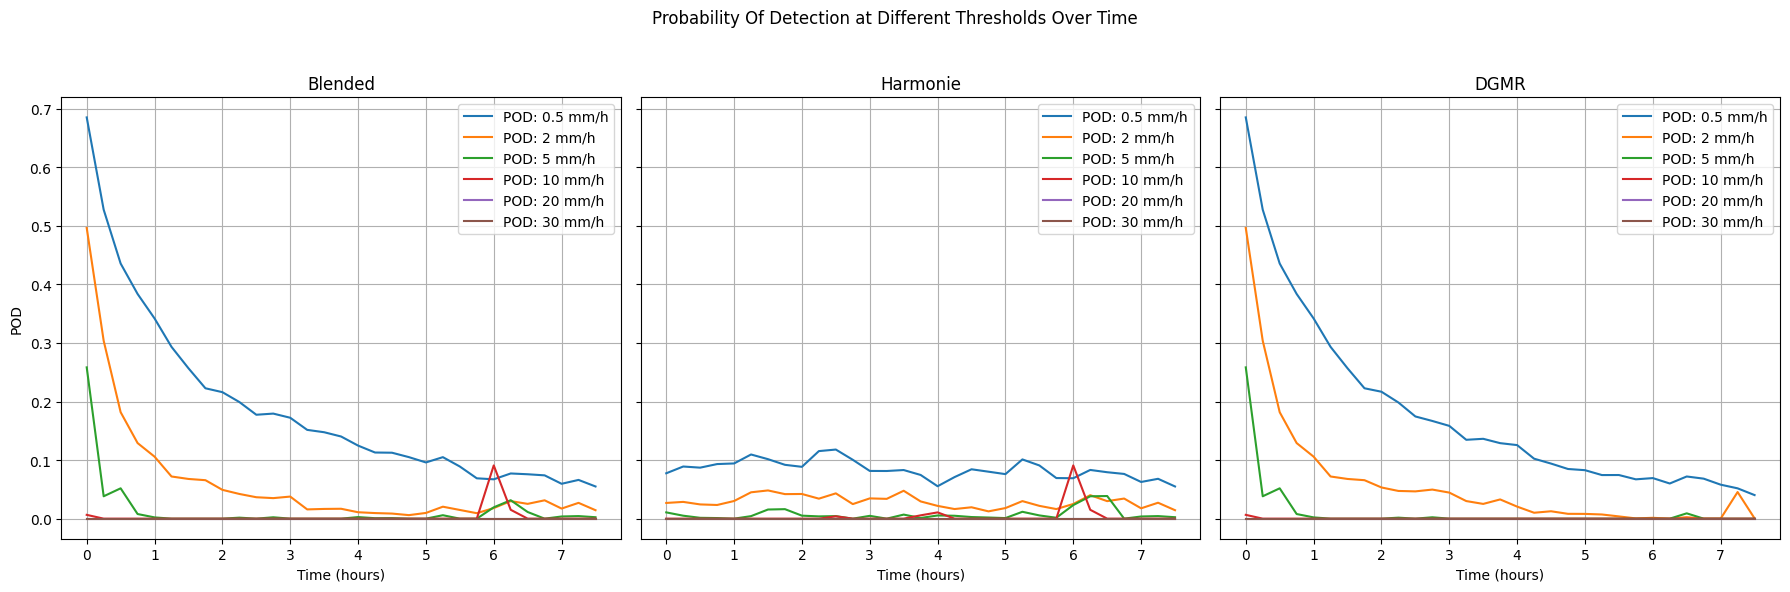

In [ ]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Define the x-axis values in hours
time_steps_hours = lead_times * 0.25  # 15 minutes is 0.25 hours

# Plot for precip_blended
for thr in thresholds:
    axes[0].plot(time_steps_hours, pod_scores_final['precip_blended'][thr], label=f"POD: {thr} mm/h")
axes[0].set_title('Blended')
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("POD")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for nwp_all
for thr in thresholds:
    axes[1].plot(time_steps_hours, pod_scores_final['nwp_all'][thr], label=f"POD: {thr} mm/h")
axes[1].set_title('Harmonie')
axes[1].set_xlabel("Time (hours)")
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for DGMR_combined_extended_down
for thr in thresholds:
    axes[2].plot(time_steps_hours, pod_scores_final['DGMR_combined_extended_down'][thr], label=f"POD: {thr} mm/h")
axes[2].set_title('DGMR')
axes[2].set_xlabel("Time (hours)")
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

plt.suptitle('Probability Of Detection at Different Thresholds Over Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

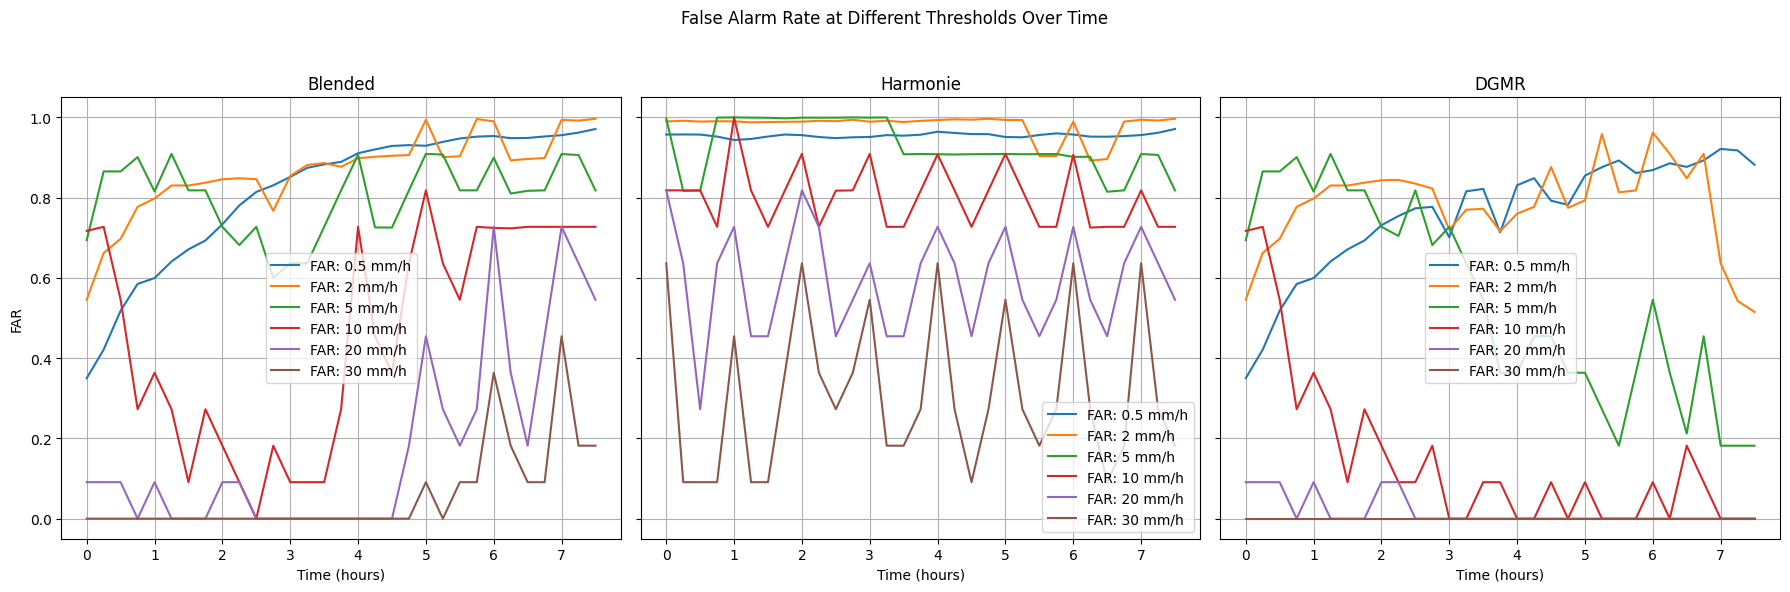

In [ ]:

# Create subplots for FAR scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Define the x-axis values in hours
time_steps_hours = lead_times * 0.25  # 15 minutes is 0.25 hours

# Plot for precip_blended FAR
for thr in thresholds:
    axes[0].plot(time_steps_hours, far_scores_final['precip_blended'][thr], label=f"FAR: {thr} mm/h")
axes[0].set_title('Blended')
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("FAR")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for nwp_all FAR
for thr in thresholds:
    axes[1].plot(time_steps_hours, far_scores_final['nwp_all'][thr], label=f"FAR: {thr} mm/h")
axes[1].set_title('Harmonie')
axes[1].set_xlabel("Time (hours)")
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for DGMR_combined_extended_down FAR
for thr in thresholds:
    axes[2].plot(time_steps_hours, far_scores_final['DGMR_combined_extended_down'][thr], label=f"FAR: {thr} mm/h")
axes[2].set_title('DGMR')
axes[2].set_xlabel("Time (hours)")
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

plt.suptitle('False Alarm Rate at Different Thresholds Over Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


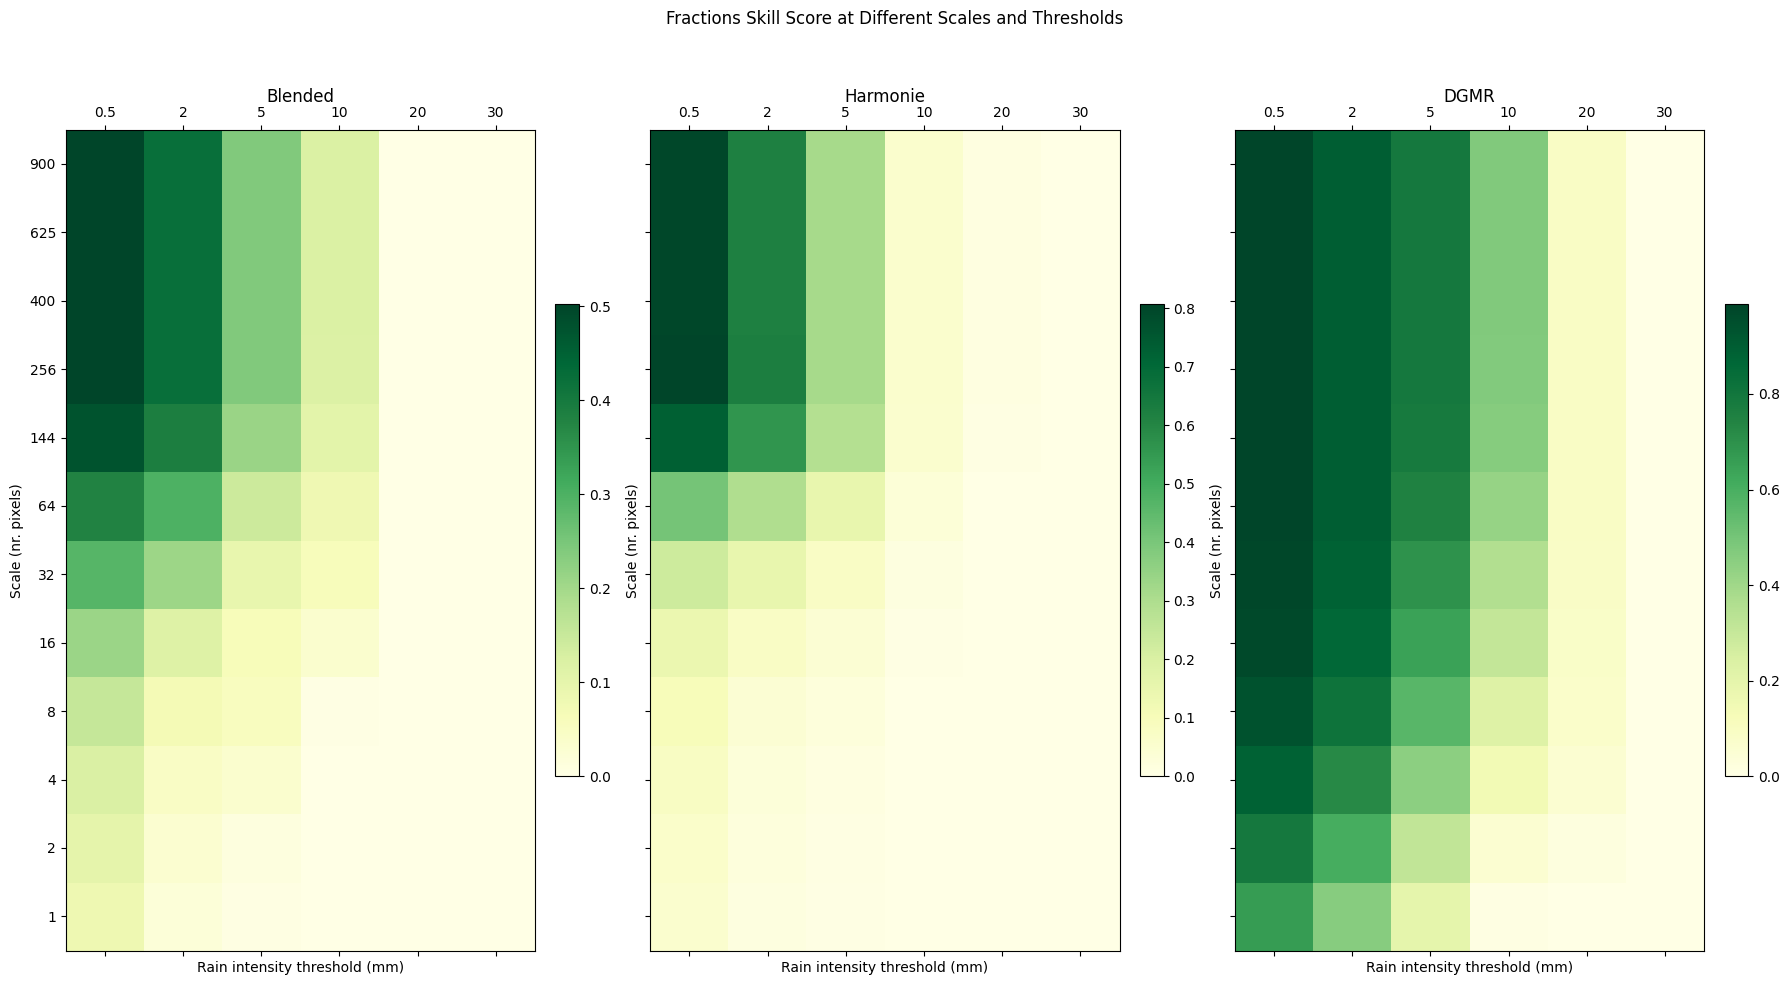

In [ ]:

# Function to plot heatmap
def plot_heatmap(ax, data, title):
    cax = ax.matshow(data, cmap='YlGn', origin='lower', aspect='auto')
    ax.set_title(title, pad=20)
    ax.set_xlabel('Rain intensity threshold (mm)')
    ax.set_ylabel('Scale (nr. pixels)')
    ax.set_xticks(np.arange(len(thresholds)))
    ax.set_xticklabels(thresholds)
    ax.set_yticks(np.arange(len(scales)))
    ax.set_yticklabels(scales)
    plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

# Prepare data for heatmaps
fss_data_blended = np.array([[fss_scores_final['precip_blended'][scale][i] for i in range(len(thresholds))] for scale in scales])
fss_data_combined = np.array([[fss_scores_final['nwp_all'][scale][i] for i in range(len(thresholds))] for scale in scales])
fss_data_dgmr = np.array([[fss_scores_final['DGMR_combined_extended_down'][scale][i] for i in range(len(thresholds))] for scale in scales])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

# Plot heatmaps
plot_heatmap(axes[0], fss_data_blended, 'Blended')
plot_heatmap(axes[1], fss_data_combined, 'Harmonie')
plot_heatmap(axes[2], fss_data_dgmr, 'DGMR')

plt.suptitle('Fractions Skill Score at Different Scales and Thresholds')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import numpy as np

# Total score calculation function
def calculate_total_score(pod_scores, far_scores, fss_scores, thresholds, scales):
    total_score = 0
    for t in range(31):  # Lead times
        for thr in thresholds:
            pod_score = pod_scores[thr][t]
            far_score = far_scores[thr][t]
            for scale in scales:
                fss_score = fss_scores[scale][t]
                if thr >= 5:
                    total_score += 2 * fss_score
                else:
                    total_score += fss_score
            if thr >= 5:
                pod_score = 2 * pod_score
                far_score = 2 * far_score
            total_score += 2 * pod_score
            total_score -= far_score
    return total_score

# Calculate the total scores for each dataset
blended_total_score = calculate_total_score(
    pod_scores_final['precip_blended'],
    far_scores_final['precip_blended'],
    fss_scores_final['precip_blended'],
    thresholds,
    scales
)

harmonie_total_score = calculate_total_score(
    pod_scores_final['nwp_all'],
    far_scores_final['nwp_all'],
    fss_scores_final['nwp_all'],
    thresholds,
    scales
)

dgmr_total_score = calculate_total_score(
    pod_scores_final['DGMR_combined_extended_down'],
    far_scores_final['DGMR_combined_extended_down'],
    fss_scores_final['DGMR_combined_extended_down'],
    thresholds,
    scales
)

# Print the total scores
print(f"Total Score for Blended: {blended_total_score}")
print(f"Total Score for Harmonie: {harmonie_total_score}")
print(f"Total Score for DGMR: {dgmr_total_score}")


Total Score for Blended: 358.94394827565606
Total Score for Harmonie: 425.352942234425
Total Score for DGMR: 1361.969094640639
